<a href="https://colab.research.google.com/github/spaceBearAmadeus/OUTDATED-studentNeedsNavigator/blob/main/ROSE_Composer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archi

In [2]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 3.7 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=19da419dd8699608c3740f7af9603fe740fd9fcc405650ff28ec7dce4e17292a
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

AUDIO_DIR = pathlib.Path("data/maestro-v2.0.0")
ANNOTATIONS_FILE = "/content/data/maestro-v2.0.0/maestro-v2.0.0.csv"

if not AUDIO_DIR.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59252736/59243107 [==============================] - 1s 0us/step


In [41]:
class Bach:

  def __init__(self, annotations_file, audio_dir, file_index:Optional[int]=None):  

    '''specifying file_index will bind a preconstructed pretty_midi object to the class
       based off of the param specified at instantiation, else you can use explicit
       methods to create a pretty midi object that is independent from any param within 
       the class'''

    self.annotations = pd.read_csv(f"{annotations_file}")
    self.audio_dir = audio_dir 
    self._SAMPLING_RATE = 44000
    if file_index:
      self.file_index = file_index 
      self.pretty_MIDI = self.__repr__(self.file_index)[0]
      print(f"New Bach Instance Created at file location index: {file_index}\n")
    else:
      print(f"New Bach Instance Created!\n")

  
  def __len__(self):

    '''return total songs in audio_dir'''

    return len(self.annotations)

  
  def __getitem__(self, midi_file_index:Optional[int]=None):

    '''returns both audio sample path and audio sample label of specified location index.
       If no midi_file_index is passed, will return path and labels for all file in dir'''

    if midi_file_index:
      audio_sample_path = self._get_audio_sample_path(midi_file_index)
      label = self._get_audio_sample_label(midi_file_index)
    else:
      audio_sample_path = self._get_audio_sample_path()
      label = self._get_audio_sample_label()
    return audio_sample_path, label 

  
  def __repr__(self, file_index):
    return self.get_pretty_midi(file_index), self.__getitem__()[0]

  
  def _get_audio_sample_path(self, midi_file_index:Optional[int]=None):

    '''method will return the path of either an individual file specified by location index OR the entire directory'''
    
    filenames = glob.glob(str(self.audio_dir/'**/*.mid*'))
    return filenames[midi_file_index] if midi_file_index \
                                      else filenames 

  
  def _get_audio_sample_label(self, midi_file_index:Optional[int]=None):
    return self.annotations.iloc[midi_file_index, 5] if midi_file_index \
                                                     else self.annotations['duration']
  
  
  def get_pretty_midi(self, midi_file_index:int):
    
    '''retrieves pretty_midi object'''
    
    pm = pretty_midi.PrettyMIDI(self.__getitem__(midi_file_index)[0])
    return pm

  
  #DATA VISUALIZATION METHODS
  def display_audio(self, pm:pretty_midi.PrettyMIDI, seconds=30):
    
    '''generates a mini .wav player in the markdown cell'''
    
    waveform = pm.fluidsynth(fs=self._SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*self._SAMPLING_RATE]
    return display.Audio(waveform_short, rate=self._SAMPLING_RATE)

  
  def fetch_inspect_MIDI_instrument(self, pm:pretty_midi.PrettyMIDI, show:Optional[bool]=False):
    
    '''retrieves instrument(s) in song, right now just [0], and shows data if show==True'''
    
    instrument = pm.instruments[0] 
    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
    if show:
      print("\n*-------------------------------------------*")
      print(f"{'            '} \033[1;36mINSTRUMENT INFORMATION\033[0m")
      print(f"*-------------------------------------------*")
      print(f"\033[0;34m{' '}NUMBER_OF_INSTRUMENTS:\033[0m {len(pm.instruments)}")
      print("*-------------------------------------------*")
      print(f"\033[0;34m{' '}INSTRUMENT_NAME:\033[0m {instrument_name}") 
      print("*-------------------------------------------*") 
      for i, note in enumerate(instrument.notes[:10]):
        note_name = pretty_midi.note_number_to_name(note.pitch)
        duration = note.end - note.start
        print(f"{' '}{i}: \033[0;31mPITCH\033[0m={note.pitch}, \033[0;32mNOTE_NAME\033[0m={note_name}, \033[0;33mDURATION\033[0m={duration:.4f}\n")
    print("*-------------------------------------------*") 
    print("\n")
    return instrument, instrument_name

  
  def midi_to_notes_df(self, 
                       midi_file_index:Optional[int]=None,
                       prettyMidi:Optional[pretty_midi.PrettyMIDI]=None, 
                       midi_file:Optional[str]=None) -> pd.DataFrame:
    
    '''if pm is given, default to the instantiated pm object, 
       else custom index with same method!'''
    
    if midi_file_index:
      instrument = self.get_pretty_midi(midi_file_index).instruments[0]
    if prettyMidi:
      instrument = prettyMidi.instruments[0]
    if midi_file:
      pm = pretty_midi.PrettyMIDI(midi_file)
      instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)#<-sort by start time
    prev_start = sorted_notes[0].start
    for note in sorted_notes:
      start = note.start 
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start
    
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

  
  def get_note_names(self, df:pd.DataFrame) -> np.ndarray:
    
    '''remember that this produces a FUNC'''
    
    return np.vectorize(pretty_midi.note_number_to_name)

  
  def plot_piano_roll(self, notes:pd.DataFrame, count:Optional[int]=None):
    if count:
      title = f"First {count} notes"
      plt.figure(figsize=(28,12))
    else:
      title = f"Entire track"
      count = len(notes['pitch'])
      plt.figure(figsize=(32,12))
    
    x = np.stack([notes['pitch'], notes['pitch']], axis=0)
    y = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(y[:, :count], 
             x[:, :count], 
             color="m", 
             marker=".",
             markersize=8,
             markerfacecolor="b",
             snap=True)
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch')
    _ = plt.title(title)

  
  def plot_note_distributions(self, notes_df:pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(notes_df, x="pitch", bins=20, kde=True)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes_df['step'], 100 - drop_percentile)
    sns.histplot(notes_df, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes_df['duration'], 100 - drop_percentile)
    sns.histplot(notes_df, x="duration", bins=np.linspace(0, max_step, 21))
  
  
  def notes_to_MIDI_file(
    self,
    notes:pd.DataFrame, 
    out_file:str, 
    instrument_name:str, 
    velocity:int=100) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi \
                        .Instrument(program=pretty_midi \
                        .instrument_name_to_program(instrument_name))
    prev_start = 0 
    for i, note in notes.iterrows():
      start = float(prev_start + note['step'])
      end = float(start + note['duration'])
      note = pretty_midi.Note(velocity=velocity,
                              pitch=int(note['pitch']),
                              start=start,
                              end=end)
      instrument.notes.append(note)
      prev_start = start
    
    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm 
    



rose = Bach(annotations_file=ANNOTATIONS_FILE, 
            audio_dir=AUDIO_DIR, 
            file_index=666)


kita = Bach(annotations_file=ANNOTATIONS_FILE,
            audio_dir=AUDIO_DIR,
            file_index=None)

New Bach Instance Created at file location index: 666

New Bach Instance Created!




*-------------------------------------------*
             INSTRUMENT INFORMATION
*-------------------------------------------*
 NUMBER_OF_INSTRUMENTS: 1
*-------------------------------------------*
 INSTRUMENT_NAME: Acoustic Grand Piano
*-------------------------------------------*
 0: PITCH=63, NOTE_NAME=D#4, DURATION=0.3346

 1: PITCH=39, NOTE_NAME=D#2, DURATION=0.1654

 2: PITCH=58, NOTE_NAME=A#3, DURATION=0.1367

 3: PITCH=46, NOTE_NAME=A#2, DURATION=0.2148

 4: PITCH=51, NOTE_NAME=D#3, DURATION=0.1549

 5: PITCH=54, NOTE_NAME=F#3, DURATION=0.1914

 6: PITCH=46, NOTE_NAME=A#2, DURATION=0.0768

 7: PITCH=39, NOTE_NAME=D#2, DURATION=0.0846

 8: PITCH=51, NOTE_NAME=D#3, DURATION=0.0534

 9: PITCH=54, NOTE_NAME=F#3, DURATION=0.0599

*-------------------------------------------*


*-------------------------------------------*




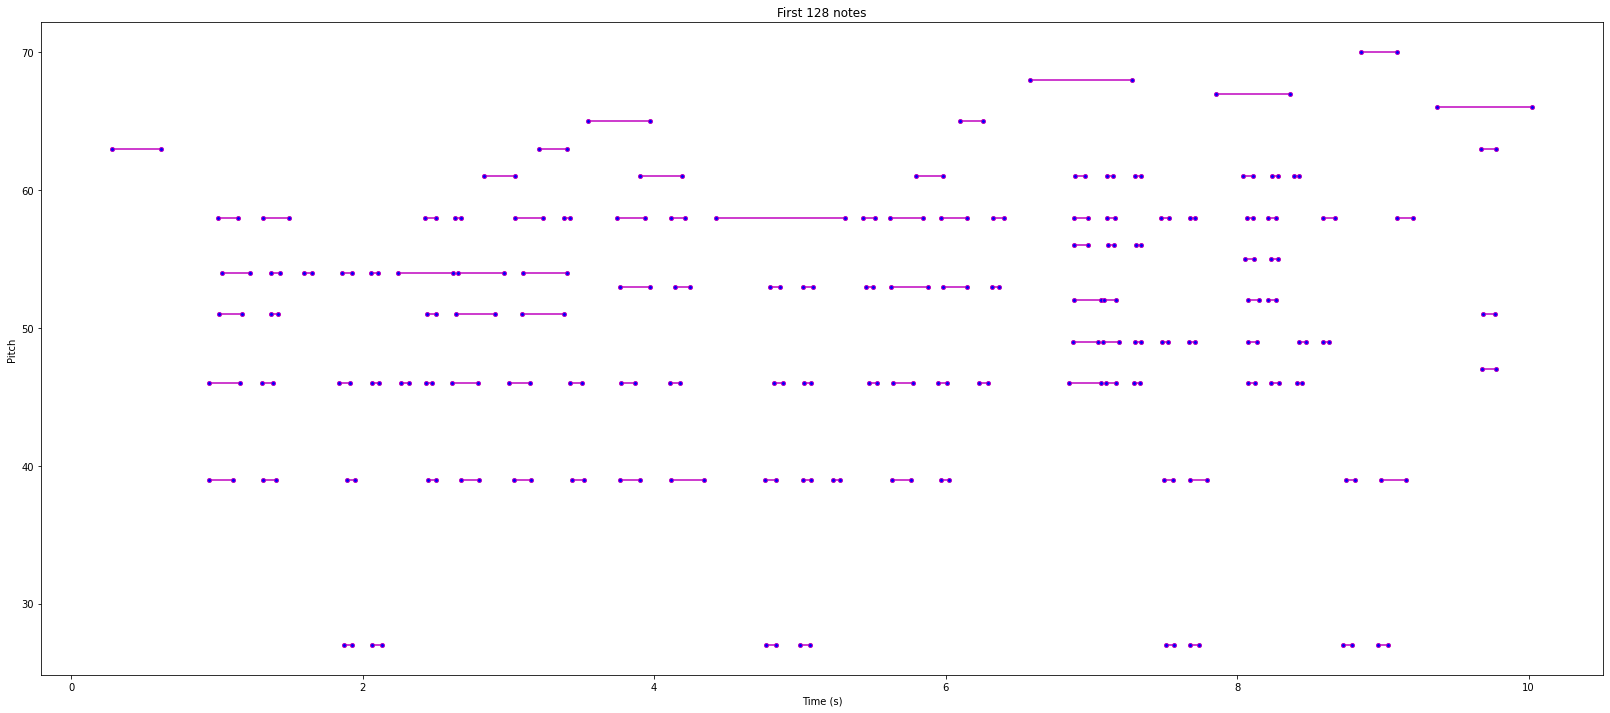

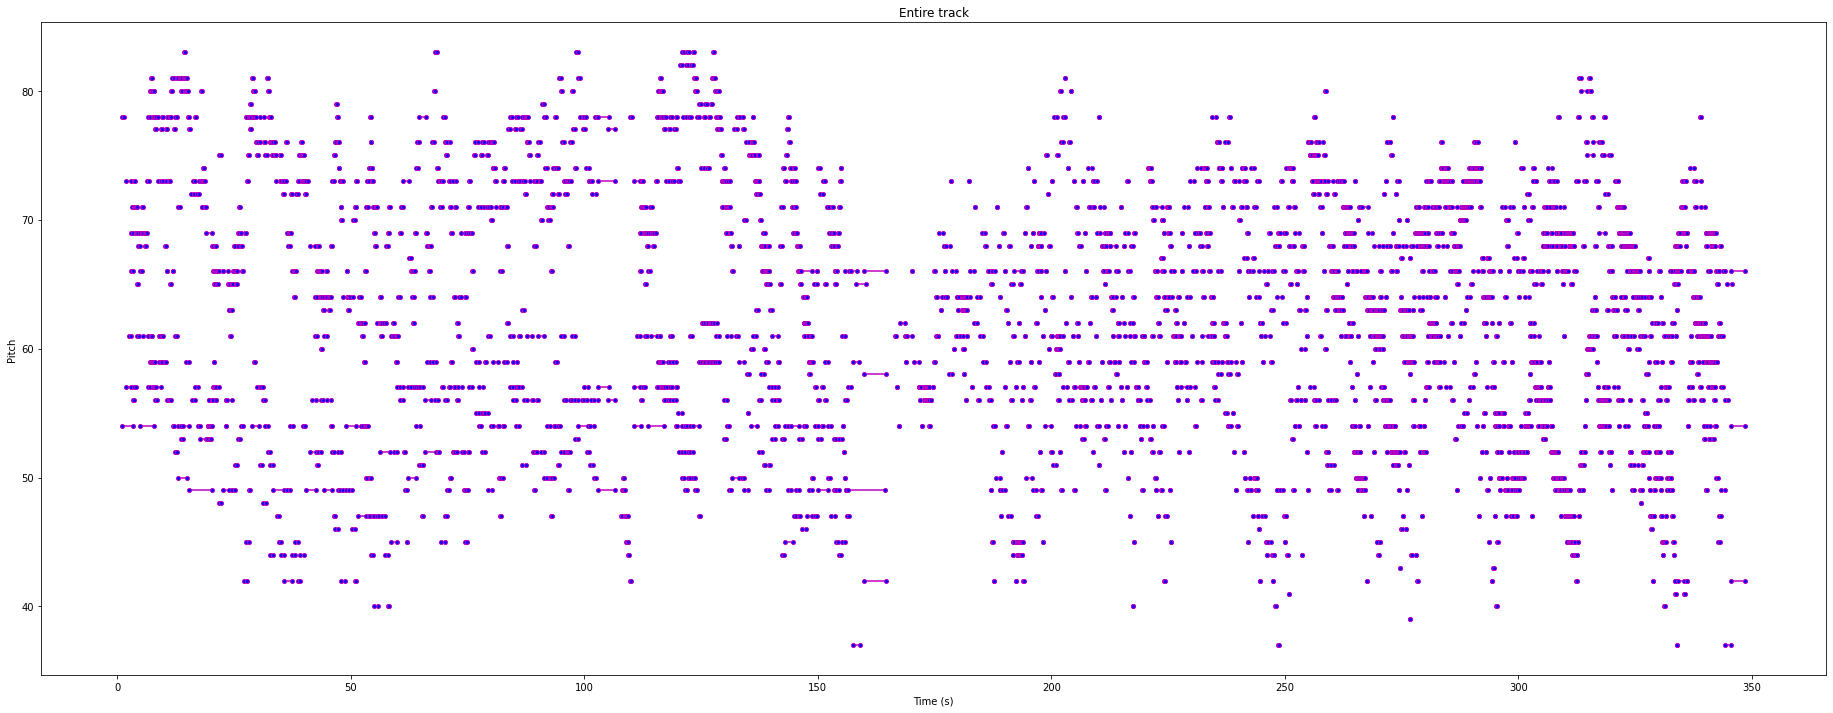

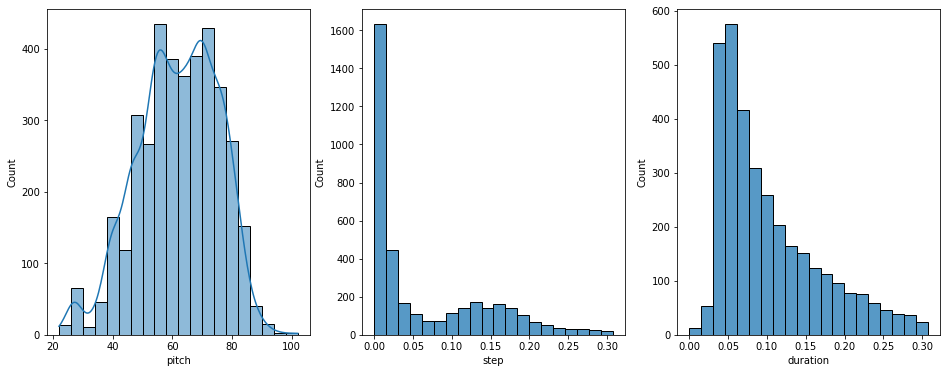

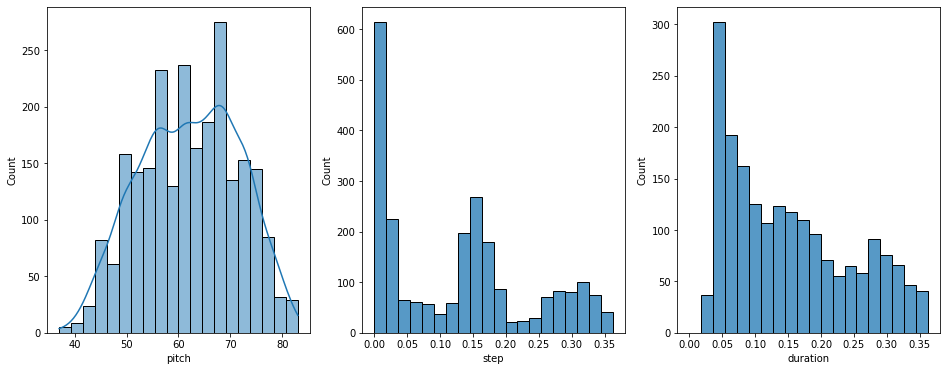

In [7]:
rose.display_audio(rose.pretty_MIDI)

pm = kita.get_pretty_midi(669) #<-index number of the sample we are inspecting
kita.display_audio(pm)

instrument1 = rose.fetch_inspect_MIDI_instrument(rose.pretty_MIDI, show=True)
instrument2 = kita.fetch_inspect_MIDI_instrument(pm)

#these perform the same function but using different params to specify different files:
song1 = rose.midi_to_notes_df(prettyMidi=rose.pretty_MIDI)
song2_cust_i = kita.midi_to_notes_df(midi_file_index=6)


rose.plot_piano_roll(song1, count=128)
kita.plot_piano_roll(song2_cust_i)

rose.plot_note_distributions(song1)
kita.plot_note_distributions(song2_cust_i)

EXAMPLE = 'example.midi'
example_midi_file = rose.notes_to_MIDI_file(notes=song1,
                                            out_file=EXAMPLE,
                                            instrument_name=instrument1[1])
rose.display_audio(example_midi_file)

In [127]:
class Amadeus(Bach):
  
  '''Amadeus is the class that inherits from Bach the ability to fetch and read music.
     Now this class will learn the music!'''
  
  def __init__(self, sampling_rate:Optional[int]=None, file_index:Optional[int]=None):

    '''You cant make a pretty midi object without a file_index, thus a child class that is 
     instantiated without this param will ALSO be devoid of a pretty midi attribute. Calling
     the file index in the child class will trigger the 'file_index' block of the parent class
     init!'''

    super().__init__(ANNOTATIONS_FILE, AUDIO_DIR, file_index)#call here even if not required!
    self.key_order = ['pitch', 'step', 'duration']
    #custom sampling rate
    if sampling_rate is not None:
      self.sampling_rate = sampling_rate
    
  def _get_all_notes(self, num_files:int, all_notes:list=[]) -> list:
    '''specify [0] for all_notes and [1] for n_notes(note count)'''
    for files in self.__getitem__()[0][:num_files]:
      notes = self.midi_to_notes_df(midi_file=files)
      all_notes.append(notes)
    all_notes = pd.concat(all_notes)
    n_notes = len(all_notes)
    '''n_notes is now available by specing [1] after this method'''
    return all_notes, n_notes


  def create_training_dataset(self, num_files:int):

    '''create a dataset consiting of n files where n is the num_files.
       ***************************************************************
       num_files(int): the number of files to add to the dataset, 
       all_notes(list)=[] : an empty container'''

    all_notes = self._get_all_notes(num_files)[0]
    n_notes = self._get_all_notes(num_files)[1]
    training_notes = np.stack([all_notes[key] for key in self.key_order], axis=1)
    training_ds = tf.data.Dataset.from_tensor_slices(training_notes)
    print(f"\033[0;31mTraining dataset derived from\033[0m {num_files} \033[0;31mfiles which consists of\033[0m {n_notes} \033[0;31mnotes!\033[0m")
    return training_ds


  def create_sequences(self,
                       dataset:tf.data.Dataset,
                       seq_length:int,
                       vocab_size=128,
                       show_spec:Optional[bool]=False) -> tf.data.Dataset:
    '''returns tf dataset in sequence form'''
    seq_length = seq_length + 1
    windows_ds = dataset.window(seq_length, shift=1,
                                stride=1, drop_remainder=True)
    
    #these are both functions
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows_ds.flat_map(flatten)

    #normalize note pitch
    def scale_pitch(x):
      x = x / [vocab_size, 1.0, 1.0]
      return x 

    def split_labels(sequences):
      inputs = sequences[:-1]
      labels_dense = sequences[-1]
      labels = {key : labels_dense[i] for i, key in enumerate(self.key_order)}
      return scale_pitch(inputs), labels 

    seq_ds = sequences.map(split_labels, 
                                 num_parallel_calls=tf.data.AUTOTUNE)
    if show_spec:
      print(f"Sequence Map:\n {seq_ds.element_spec}\n")
    return seq_ds

  def batch_ds(self, num_files:int, seq_len:int, seq_ds, batch_size:Optional[int]=64):
    
    '''last arg is a dataset of a song broken into seq_lenSequences.
     batch examples and config dataset for interperentation. Takes in
     the create_training_dataset -> create_sequences ds as "seq_ds"'''

    '''batch_size is set to 64 by default'''

    n_notes = self._get_all_notes(num_files)[1] #n_notes value from class
    buff = n_notes - seq_len #number of items in dataset
    train_ds = (seq_ds \
                .shuffle(buff).batch(batch_size, drop_remainder=True) \
                .cache().prefetch(tf.data.experimental.AUTOTUNE))
    return train_ds





In [128]:
#example of class without params(wanting to specify pretty_midi object explicitly)
mozart = Amadeus()

#example of class with built in pm object based on parameters. Also includes other constructor variables
haydn = Amadeus(sampling_rate=16000,
                file_index=rose.file_index)

New Bach Instance Created!

New Bach Instance Created at file location index: 666



In [129]:
N_SEQUENCES = 50
N_FILES = 5

#create training data from num_files as arg
X_train_raw = haydn.create_training_dataset(N_FILES)

#create ds that breaks raw train into specified n_sequences, show_spec if you wanto to print that
X_train_seq = haydn.create_sequences(X_train_raw, N_SEQUENCES, show_spec=True)

#batch out data, ensuring that seq_len(train_ds) == seq_len(X_train_seq)
train_ds = haydn.batch_ds(num_files=N_FILES,
                          seq_len=N_SEQUENCES,
                          seq_ds=X_train_seq)

Training dataset derived from 5 files which consists of 56936 notes!
Sequence Map:
 (TensorSpec(shape=(50, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})



In [ ]:
'''to determine train test split, let us find our 80/20 of len(audio_dir)'''